In [2]:
%pip install standard-precip

Note: you may need to restart the kernel to use updated packages.


In [147]:
import pandas as pd
from scipy.stats import gamma, norm

from standard_precip.spi import SPI
from standard_precip.utils import plot_index

In [86]:
input_data = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\modelled_data_snowdrought\onset_to_peak_data.csv'
output_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\SPI\\'


In [133]:
rainfall_data = pd.read_csv(input_data)
rainfall_data.set_index('time', inplace=True)

display(rainfall_data.head())

,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change,cumulative_P
time,,,,,,,,,
1981-02-11,1,-116.13797,51.33459,152.250,0.000000,2000_2500m,1980,0.570312,0.000000
1980-11-07,1,-116.13797,51.33459,27.000,2.128011,2000_2500m,1980,0.000000,2.128011
1980-12-21,1,-116.13797,51.33459,110.625,3.271602,2000_2500m,1980,0.000000,5.399613
1980-10-25,1,-116.13797,51.33459,12.625,0.000000,2000_2500m,1980,27.875000,5.399613
1980-11-13,1,-116.13797,51.33459,40.500,0.007695,2000_2500m,1980,13.000000,5.407308


In [134]:
# remove lat, lon and SWE columns if they exist
rainfall_data = rainfall_data.drop(columns=['lat', 'lon', 'SWE','daily_SWE_change','cumulative_P'], errors='ignore')

# Rename columns if needed (update based on your actual header)
rainfall_data.columns = [col.strip() for col in rainfall_data.columns]
# The index may not be datetime yet, so convert it first
rainfall_data.index = pd.to_datetime(rainfall_data.index)

# The index is now datetime, so we can just assign it to a new column if needed
rainfall_data['Date'] = rainfall_data.index

# Filter for Oct–May only
rainfall_data = rainfall_data[rainfall_data.index.month.isin([10, 11, 12, 1, 2, 3, 4, 5])]

display(rainfall_data.head())

,Grid_id,Precipitation,Elevation_Category,Season_year,Date
time,,,,,
1981-02-11,1,0.000000,2000_2500m,1980,1981-02-11
1980-11-07,1,2.128011,2000_2500m,1980,1980-11-07
1980-12-21,1,3.271602,2000_2500m,1980,1980-12-21
1980-10-25,1,0.000000,2000_2500m,1980,1980-10-25
1980-11-13,1,0.007695,2000_2500m,1980,1980-11-13


In [135]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    rainfall_data
    .groupby(['Grid_id', 'Season_year', pd.Grouper(key='Date', freq='M')])['Precipitation']
    .sum()
    .reset_index()
)

# Add elevation category for each Grid_id
# Get unique mapping from Grid_id to Elevation_Category
elevation_map = rainfall_data[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

display(monthly_precip.head())

,Grid_id,Season_year,Date,Precipitation,Elevation_Category
0,1,1980,1980-10-31,9.161071,2000_2500m
1,1,1980,1980-11-30,50.295086,2000_2500m
2,1,1980,1980-12-31,108.955549,2000_2500m
3,1,1980,1981-01-31,13.916898,2000_2500m
4,1,1980,1981-02-28,38.431036,2000_2500m


In [136]:
# Calculate monthly average precipitation for each Elevation_Category, Season_year, and month
monthly_avg = (
    monthly_precip
    .groupby(['Elevation_Category', 'Season_year', monthly_precip['Date']])['Precipitation']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_P" for col in monthly_avg.columns]

display(monthly_avg.head(10))

1000_1500m_P  1500_2000m_P  2000_2500m_P  500_1000m_P
Season_year Date                                                             
1980        1980-10-31     11.278646     23.107287     16.283314     6.029624
            1980-11-30     23.173287     32.786186     52.304052    12.598151
            1980-12-31     15.068457     33.435977     94.355993    17.063118
            1981-01-31      9.967167     10.810990     11.316449    11.567617
            1981-02-28      8.874055     13.449608     29.459216     2.885608
            1981-03-31      9.372507     10.285527     14.930461          NaN
            1981-04-30     11.146534     15.148091     28.866890          NaN
            1981-05-31     94.505921     93.067019     60.196373          NaN
1981        1981-10-31     15.946284     13.428639     33.749206     8.283148
            1981-11-30      4.466762      6.709451     12.219782     7.166000

In [88]:
# Save the combined data to a CSV file
monthly_avg.to_csv(output_path + 'monthly_precipitation.csv')


In [137]:
# Group by season and sum the precipitation for each column
seasonal_precip = monthly_avg.groupby('Season_year').sum(numeric_only=True)

display(seasonal_precip)


,1000_1500m_P,1500_2000m_P,2000_2500m_P,500_1000m_P
Season_year,,,,
1980,183.386574,232.090686,307.712748,50.144119
1981,108.039912,118.250639,249.130062,86.981536
1982,77.440414,113.179815,185.592117,66.073298
1983,32.734949,171.032890,213.118394,54.822217
1984,93.088361,141.939992,207.965579,75.855398
1985,157.692104,206.002977,306.397238,49.548402
1986,67.633892,100.343192,202.945196,58.452687
1987,54.421573,182.154022,199.179332,43.789924
1988,85.434439,147.419844,227.209128,67.098384


In [142]:
# Calculate SPI for each elevation column and season year
spi_results = {}

for col in seasonal_precip.columns:
    # Drop NaNs and non-positive values for SPI calculation
    precip = seasonal_precip[col].dropna()
    precip = precip[precip > 0]  # Only positive values
    if len(precip) < 10:  # Not enough data to fit
        spi_results[col.replace('_P', '_SPI')] = [float('nan')] * len(seasonal_precip)
        continue
    shape, loc, scale = gamma.fit(precip, floc=0)
    cdf = gamma.cdf(seasonal_precip[col], shape, loc=loc, scale=scale)
    #cdf = cdf.clip(1e-10, 1 - 1e-10)  # Avoid exactly 0 or 1
    spi = norm.ppf(cdf)
    spi_results[col.replace('_P', '_SPI')] = spi

# Combine SPI results into a DataFrame
spi_df = pd.DataFrame(spi_results, index=seasonal_precip.index)

display(spi_df.head(10))

,1000_1500m_SPI,1500_2000m_SPI,2000_2500m_SPI,500_1000m_SPI
Season_year,,,,
1980,1.362011,0.758803,0.958053,-0.959545
1981,-0.185866,-1.591445,-0.053282,0.447447
1982,-1.029963,-1.727498,-1.350490,-0.286254
1983,-2.860879,-0.369135,-0.756530,-0.748227
1984,-0.574496,-1.004455,-0.863570,0.073822
1985,0.891332,0.304451,0.936808,-0.987418
1986,-1.348910,-2.092079,-0.969604,-0.592622
1987,-1.834688,-0.145664,-1.050317,-1.269673
1988,-0.790104,-0.878428,-0.472487,-0.246904


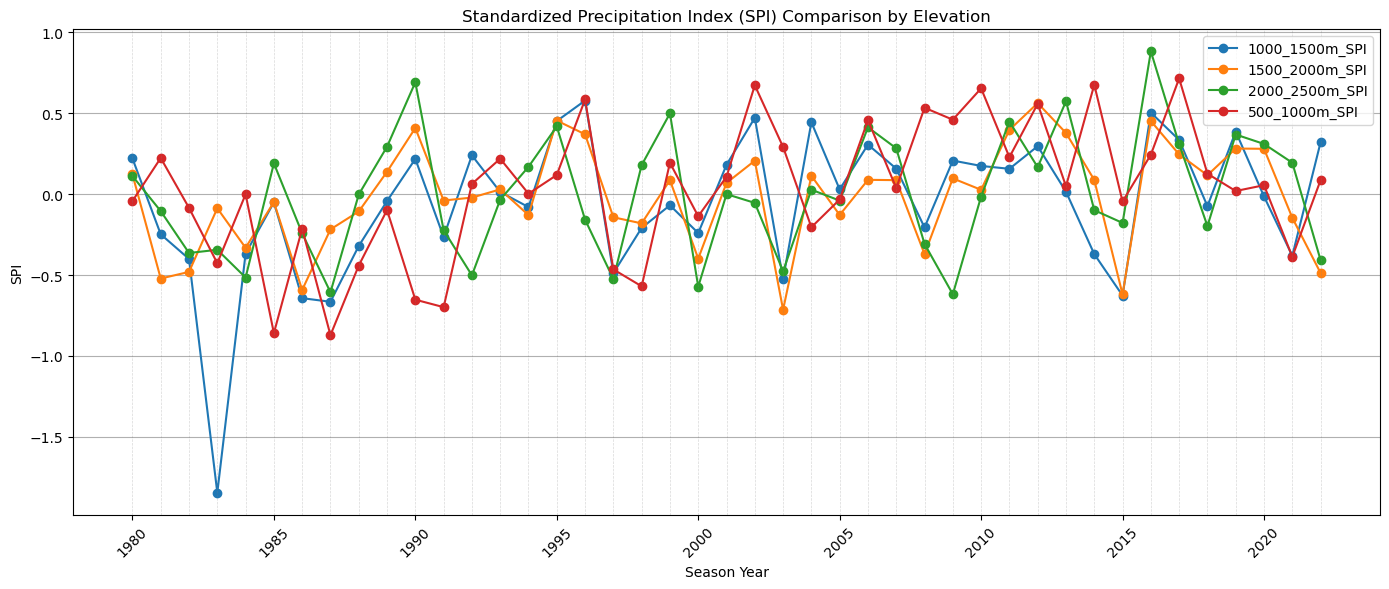

In [ ]:
import matplotlib.pyplot as plt

# Plot all SPI columns from spi_df on the same graph for comparison
plt.figure(figsize=(14, 6))
for col in spi_df.columns:
    plt.plot(spi_df.index, spi_df[col], marker='o', label=col)

plt.xlabel('Season Year')
plt.ylabel('SPI')
plt.title('Standardized Precipitation Index (SPI) Comparison by Elevation')
plt.legend()
plt.grid(True, axis='y')
for year in spi_df.index:
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(
    ticks=spi_df.index[::5],  # every 5th year
    labels=spi_df.index[::5],
    rotation=45
)
plt.tight_layout()
plt.show()

In [164]:
from scipy.stats import gamma, norm

spi = SPI()

monthly_avg_reset = seasonal_precip.reset_index()  # This will make 'Season_year' a column

# If SPI expects a datetime column, convert 'Season_year' to datetime (e.g., use Dec 31 of each year)
monthly_avg_reset['Season_year_dt'] = pd.to_datetime(monthly_avg_reset['Season_year'].astype(str) + '-12-31')

# Calculate SPI for each precipitation column in monthly_avg_reset

spi_results = {}
for col in precip_cols:
    precip = monthly_avg_reset[col].dropna()
    precip = precip[precip > 0]
    if len(precip) < 10:
        spi_results[f"{col}_calculated_index"] = [float('nan')] * len(monthly_avg_reset)
        continue
    shape, loc, scale = gamma.fit(precip, floc=0)
    cdf = gamma.cdf(monthly_avg_reset[col], shape, loc=loc, scale=scale)
    spi = norm.ppf(cdf)
    spi_results[f"{col}_calculated_index"] = spi

# Add SPI columns to monthly_avg_reset
for col, values in spi_results.items():
    monthly_avg_reset[col] = values

# Optionally, assign to df_spi for display
df_spi = monthly_avg_reset[['Season_year_dt'] + precip_cols + [f"{col}_calculated_index" for col in precip_cols]]

display(df_spi.head(10))

,Season_year_dt,1000_1500m_P,1500_2000m_P,2000_2500m_P,500_1000m_P,1000_1500m_P_calculated_index,1500_2000m_P_calculated_index,2000_2500m_P_calculated_index,500_1000m_P_calculated_index
0,1980-12-31,183.386574,232.090686,307.712748,50.144119,1.362011,0.758803,0.958053,-0.959545
1,1981-12-31,108.039912,118.250639,249.130062,86.981536,-0.185866,-1.591445,-0.053282,0.447447
2,1982-12-31,77.440414,113.179815,185.592117,66.073298,-1.029963,-1.727498,-1.350490,-0.286254
3,1983-12-31,32.734949,171.032890,213.118394,54.822217,-2.860879,-0.369135,-0.756530,-0.748227
4,1984-12-31,93.088361,141.939992,207.965579,75.855398,-0.574496,-1.004455,-0.863570,0.073822
5,1985-12-31,157.692104,206.002977,306.397238,49.548402,0.891332,0.304451,0.936808,-0.987418
6,1986-12-31,67.633892,100.343192,202.945196,58.452687,-1.348910,-2.092079,-0.969604,-0.592622
7,1987-12-31,54.421573,182.154022,199.179332,43.789924,-1.834688,-0.145664,-1.050317,-1.269673
8,1988-12-31,85.434439,147.419844,227.209128,67.098384,-0.790104,-0.878428,-0.472487,-0.246904
9,1989-12-31,107.968426,205.312076,304.173999,77.854764,-0.187634,0.291913,0.900766,0.143530


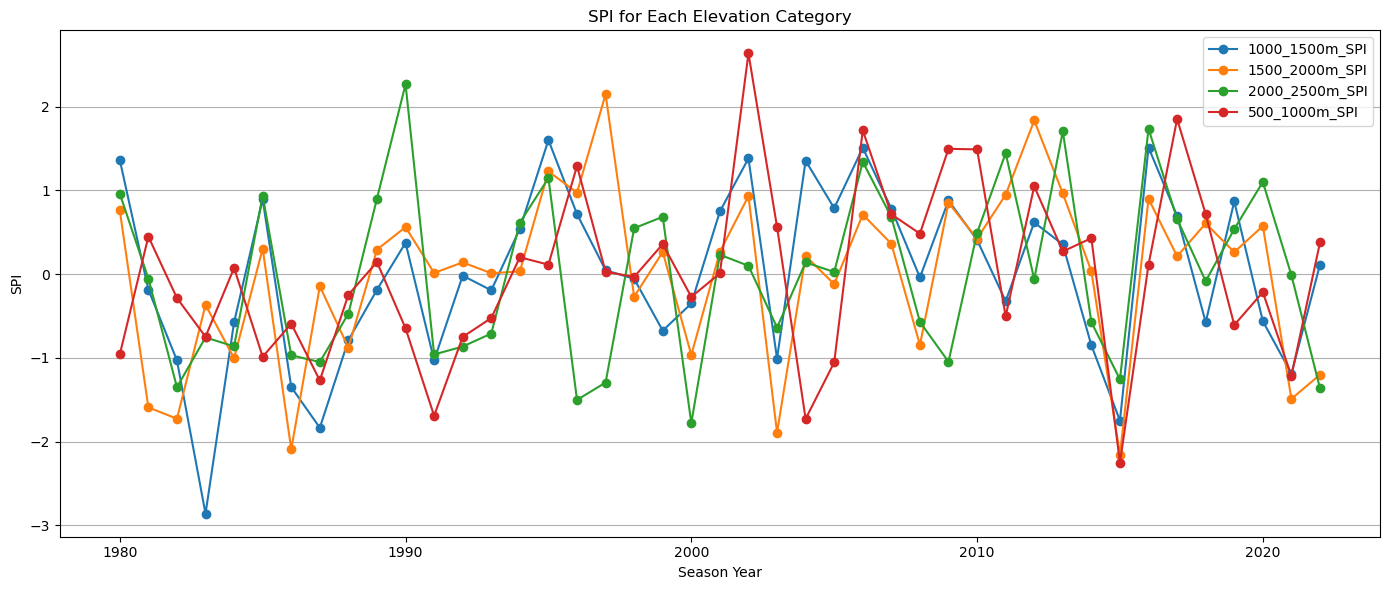

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for col in [c for c in spi_df.columns if c.endswith('_SPI')]:
    plt.plot(spi_df.index, spi_df[col], marker='o', label=col)

plt.xlabel('Season Year')
plt.ylabel('SPI')
plt.title('SPI for Each Elevation Category')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()